In [1]:
# libraries
import pandas as pd
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

**Current Account 2022**

In [2]:
df_current = pd.read_csv("Transazioni_Azienda ABC - Foglio1.csv")

In [3]:
# translate from it to en
df_current.rename(columns={'data ':'date', 'categoria':'categories'}, inplace=True)
df_current['categories'] = np.where(df_current['categories']=='INCASSO FATTURA', 'Invoice Collection', df_current['categories'])
df_current['categories'] = np.where(df_current['categories']=='STIPENDI', 'Salaries', df_current['categories'])
df_current['categories'] = np.where(df_current['categories']=='RIMBORSO FINANZIAMENTO', 'Financing Repayment', df_current['categories'])
df_current['categories'] = np.where(df_current['categories']=='UTENZE', 'Utilities', df_current['categories'])
df_current['categories'] = np.where(df_current['categories']=='PAGAMENTO FORNITORI', 'Supplier Repayment', df_current['categories'])
df_current['categories'] = np.where(df_current['categories']=='EROGAZIONE FINANZIAMENTO', 'Financing Disbursement', df_current['categories'])
df_current['categories'] = np.where(df_current['categories']=='PAGAMENTO FATTURA', 'Invoice Payment', df_current['categories'])

# clean df date
df_current['date'] = pd.to_datetime(df_current['date'], format='%d/%m/%Y') #.dt.strftime('%d-%m-%Y')
df_current.sort_values(by=['date'])

# clean df amount
df_current['amount'] = df_current['amount'].str.replace('€', '')
df_current['amount'] = df_current['amount'].str.replace('.', '')
df_current['amount'] = df_current['amount'].str.replace(',', '.')
df_current['amount'] = df_current['amount'].str.replace(' ', '')
df_current['amount'] = pd.to_numeric(df_current['amount'])

# create cumulative sum column
df_current['cumsum_amount'] = df_current['amount'].cumsum()

# debit - credit to make it more readable
df_current['debit'] = np.where(df_current['amount']<0, df_current['amount'],0)
df_current['credit'] = np.where(df_current['amount']>0, df_current['amount'],0)
df_current.drop(columns=['amount'], inplace=True)

# sort columns
df_current = df_current[['date','categories','debit','credit','cumsum_amount']]

df_current

/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_43595/1944890406.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_current['amount'] = df_current['amount'].str.replace('.', '')


,date,categories,debit,credit,cumsum_amount
0,2022-01-04,Invoice Collection,0.0,5000.00,5000.00
1,2022-01-13,Invoice Collection,0.0,4800.00,9800.00
2,2022-01-15,Salaries,-6000.0,0.00,3800.00
3,2022-01-15,Financing Repayment,-1200.0,0.00,2600.00
4,2022-01-22,Invoice Collection,0.0,5400.00,8000.00
...,...,...,...,...,...
110,2022-12-15,Financing Repayment,-1700.0,0.00,709.80
111,2022-12-21,Invoice Collection,0.0,12666.67,13376.47
112,2022-12-21,Supplier Repayment,-9284.0,0.00,4092.47
113,2022-12-30,Invoice Collection,0.0,12866.67,16959.14


In [4]:
# current account transactions 2022 per category
df_current.groupby('categories')[['debit','credit']].sum()

,debit,credit
categories,,
Financing Disbursement,0.00,10000.00
Financing Repayment,-17900.00,0.00
Invoice Collection,0.00,363533.46
Invoice Payment,-40000.00,0.00
Salaries,-46000.00,0.00
Supplier Repayment,-253042.01,0.00
Utilities,-9066.31,0.00


In [5]:
df_current[df_current['categories']=='Invoice Payment']

,date,categories,debit,credit,cumsum_amount
69,2022-08-15,Invoice Payment,-8000.0,0.0,2515.12
80,2022-09-15,Invoice Payment,-8000.0,0.0,2995.80
89,2022-10-15,Invoice Payment,-8000.0,0.0,1240.36
98,2022-11-15,Invoice Payment,-8000.0,0.0,-62.48
109,2022-12-15,Invoice Payment,-8000.0,0.0,2409.80


In [6]:
df_current[df_current['categories']=='Financing Disbursement']

,date,categories,debit,credit,cumsum_amount
46,2022-05-30,Financing Disbursement,0.0,10000.0,11882.32


In [7]:
df_current[df_current['categories']=='Financing Repayment']

,date,categories,debit,credit,cumsum_amount
3,2022-01-15,Financing Repayment,-1200.0,0.0,2600.00
11,2022-02-15,Financing Repayment,-1200.0,0.0,3332.00
20,2022-03-15,Financing Repayment,-1200.0,0.0,408.85
31,2022-04-15,Financing Repayment,-1200.0,0.0,37.38
40,2022-05-15,Financing Repayment,-1200.0,0.0,-1724.57
52,2022-06-15,Financing Repayment,-1700.0,0.0,6797.66
61,2022-07-15,Financing Repayment,-1700.0,0.0,3587.11
70,2022-08-15,Financing Repayment,-1700.0,0.0,815.12
81,2022-09-15,Financing Repayment,-1700.0,0.0,1295.80
90,2022-10-15,Financing Repayment,-1700.0,0.0,-459.64


We can see that the ABC Company already has at least one loan which was given before 2022, as we see monthly repayments of €1200 from January. On the 30th of May 2022, ABC Company got one more loan of amount €10K and started monthly repayments of €500 from July. By the end of the year 2022 (7 installements), ABC company paid €3.5K of the €10K loan, so we can assume that this was a long-term loan of a more than 1.5 years plan.

In [8]:
# how much was on debit / credit the whole year
total_debit = round(df_current["debit"].sum(),2)
total_credit = round(df_current["credit"].sum(),2)
balance = round(total_credit + total_debit,2)

# average amount
debit_avg = round(df_current['debit'].mean(),2)
credit_avg = round(df_current['credit'].mean(),2)

# minimum cash flow throughout the year
min_cash = round(df_current['cumsum_amount'].min(),2)

print(f'Debit Total: {total_debit}')
print(f'Credit Total: {total_credit}')
print(f'Cash Flow Balance as of 2022: {balance}')
print()
print(f'Debit Average: {debit_avg}')
print(f'Credit Average: {credit_avg}')
print()
print(f'Min Cash Flow: {min_cash}')

Debit Total: -366008.32
Credit Total: 373533.46
Cash Flow Balance as of 2022: 7525.14

Debit Average: -3182.68
Credit Average: 3248.12

Min Cash Flow: -1724.57


End of the year cash flow is €7525.14, and we already calculated the ABC Company repayed €3500 of the €10K loan by the end of the year. So theoretically, ABC Company could have then and there repayed the entirety of the €10K loan with the amount left in the current account at the end of the year, and if needed to be refinanced.

In [9]:
# separate the data into months
monthly_tables = {}
balance = []

for month in df_current['date'].dt.month.unique():
    month_data = df_current[df_current['date'].dt.month == month]
    monthly_tables[month] = month_data

for month, table in monthly_tables.items():
    total_debit = round(table["debit"].sum(),2)
    total_credit = round(table["credit"].sum(),2)
    total_transactions = round(total_credit + total_debit,2)
    end_balance = round(table['cumsum_amount'].iloc[-1],2)

    balance.append(end_balance)

    print(f'Table for Month {month}:')
    print(table)
    print(f'Debit Total: {total_debit}')
    print(f'Credit Total: {total_credit}')
    print(f'Total Transactions: {total_transactions}')
    print(f'End Balance of Month {month}: {end_balance}')
    print()

Table for Month 1:
        date           categories    debit   credit  cumsum_amount
0 2022-01-04   Invoice Collection     0.00  5000.00        5000.00
1 2022-01-13   Invoice Collection     0.00  4800.00        9800.00
2 2022-01-15             Salaries -6000.00     0.00        3800.00
3 2022-01-15  Financing Repayment -1200.00     0.00        2600.00
4 2022-01-22   Invoice Collection     0.00  5400.00        8000.00
5 2022-01-30            Utilities  -800.00     0.00        7200.00
6 2022-01-31   Invoice Collection     0.00  5466.67       12666.67
7 2022-01-31   Supplier Repayment -4000.67     0.00        8666.00
Debit Total: -12000.67
Credit Total: 20666.67
Total Transactions: 8666.0
End Balance of Month 1: 8666.0

Table for Month 2:
         date           categories    debit   credit  cumsum_amount
8  2022-02-09   Invoice Collection     0.00  5666.67       14332.67
9  2022-02-09   Supplier Repayment -3800.67     0.00       10532.00
10 2022-02-15             Salaries -6000.00     0.

In [10]:
# end of month balance table
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_balance = pd.DataFrame({'end of month balance': balance}, index = months)
monthly_balance

,end of month balance
January,8666.00
February,5826.18
March,3322.04
April,1260.09
May,11882.32
June,8371.77
July,7882.45
August,5380.46
September,3325.02
October,4804.85


In [11]:
# minimum amount on debit throughout the year
df_current[df_current['debit'] == df_current['debit'].min()]

,date,categories,debit,credit,cumsum_amount
114,2022-12-30,Supplier Repayment,-9434.0,0.0,7525.14


In [12]:
# maximum amount on credit throughout the year
df_current[df_current['credit'] == df_current['credit'].max()]

,date,categories,debit,credit,cumsum_amount
113,2022-12-30,Invoice Collection,0.0,12866.67,16959.14


Although we see that at the end of every month the cash flow is positive, there is a point in mid May that the cash flow is negative with a minimum amount of -€1724.54 . Hence, we can see that without the loan of €10K in May, the company couldn't have repayed its debts and hence couldn't have made the credit. As a result, although this company can repay at the end of the month and year everything borrowed, it needs this support during the year.

Let’s assume that the agreed interest rate is < 10%, then ABC should pay a maximum total of €11,000 to LIQI in 9 months (as we promise in our website). Therefore, the monthly instalment should be less than €1,222. Since, for all months of 2022, the end of month balance of cash flow was at least twice the amount of €1,222, then we can assume that the same will occur for 2023 and thus ABC will have enough to pay the LIQI the monthly fee.

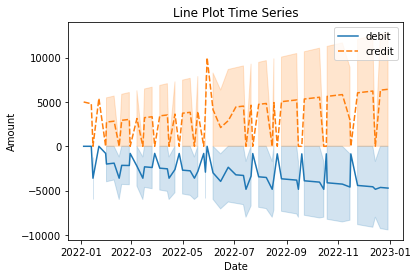

In [13]:
# plot current account data as a time series to visually see what is going on
df = df_current[['date','debit','credit']]

# set the date column as the index of the dataframe
df.set_index('date', inplace=True)

# plot
sns.lineplot(data=df)
plt.title("Line Plot Time Series")
plt.xlabel("Date")
plt.ylabel("Amount")

plt.show()

**Financial Statement 2021**

In [14]:
# load and parse the file
xmlTree = ET.parse('bilancio_test.xml')

elemList = []

for elem in xmlTree.iter():
    elemList.append(elem.tag)

# now I remove duplicities - by convertion to set and back to list
elemList = list(set(elemList))

In [15]:
def intr_doc(xml_doc):
    attr = xml_doc.attrib

    for tag in elemList:
        for xml in xml_doc.iter(tag):
            doc_dict = attr.copy()
            doc_dict.update(xml.attrib)
            doc_dict['tag'] = tag
            doc_dict['data'] = xml.text

            yield doc_dict

df_fs = pd.DataFrame(list(intr_doc(xmlTree.getroot())))

In [16]:
# clean data
df_fs['data'] = df_fs['data'].str.replace(" ", "")
df_fs['data'] = df_fs['data'].str.replace("\n", "")
df_fs.rename(columns={'data':'amount'}, inplace=True)

# remove NAs
df_fs = df_fs[~df_fs['unitref'].isnull()]

# remove columns that are not necessary
df_fs.drop(columns = ['version','decimals','nazione','scheme','id'], inplace=True)

# rename tag column
df_fs['tag'] = df_fs['tag'].map(lambda x: x.split('}')[-1])

df_fs.reset_index(drop=True)

# make amount numeric
df_fs['amount'] = pd.to_numeric(df_fs['amount'])

print(df_fs)


     contextref unitref                                                tag  \
0    i_Corrente     eur                  totaleimmobilizzazioniimmateriali   
2    d_Corrente     eur           valoreproduzionealtriricaviproventialtri   
3    d_Corrente     eur  acquisizionieserciziopartecapitalecorrisponden...   
4    i_Corrente     eur                              totalepatrimonionetto   
5    d_Corrente     eur  alienazionieserciziovalorenominaleazioniquotes...   
..          ...     ...                                                ...   
104  d_Corrente     eur    acquisizionieserciziocorrispettivoazioniproprie   
105  i_Corrente     eur           patrimonionettoriservasoprapprezzoazioni   
110  d_Corrente     eur  alienazionieserciziopartecapitalecorrispondent...   
111  d_Corrente     eur  alienazionieserciziocorrispettivoazioniquoteso...   
112  i_Corrente     eur                               sindacianticipazioni   

     amount  
0     74819  
2       260  
3         0  
4     8

In [17]:
# export tag to be able to translate it from italian to english
df_fs['tag'].to_csv('./tag.csv')

# import transalted tag
df_tag_en = pd.read_csv('tag_en.csv', sep=',')

# merge the two dfs to get the replace the it with the en tag
df_fs = pd.merge(df_fs, df_tag_en, on='tag')
df_fs.drop(columns = ['tag'], inplace = True)

print(df_fs)

    contextref unitref  amount  \
0   i_Corrente     eur   74819   
1   d_Corrente     eur     260   
2   d_Corrente     eur       0   
3   i_Corrente     eur   85927   
4   d_Corrente     eur       0   
..         ...     ...     ...   
68  d_Corrente     eur       0   
69  i_Corrente     eur  129982   
70  d_Corrente     eur       0   
71  d_Corrente     eur       0   
72  i_Corrente     eur       0   

                                               tag_en  
0                             total intangible assets  
1   value produced from other revenues and profits...  
2   compensation of corresponding share capital in...  
3                                    total net equity  
4   compensation of shares in controlling companie...  
..                                                ...  
68  compensation of own shares at nominal value th...  
69             net equity surplus from share premiums  
70  compensation of corresponding share capital in...  
71  compensation of shares in c

**Checking to see whether to remove 0 values from financial statement for simplicity**

In general, removing zero values from a financial statement may not be necessary for your analysis to decide whether to approve the short-term funding request. However, it depends on the context and the purpose of the analysis.

- If a value of zero indicates a lack of activity or a negligible amount, then it may not be meaningful and could be removed to simplify the analysis. 
- However, if the value of zero represents an important aspect of the company's financial situation, such as an absence of debt or no outstanding liabilities, then it should be kept in the analysis.

It is always important to consider the context and the purpose of the analysis before making any decisions on modifying the data.

In [18]:
df_fs_0 = df_fs[df_fs['amount']==0].reset_index(drop=True)
df_fs_0['tag_en'].unique()

array(['compensation of corresponding share capital in own shares through exercise',
       'compensation of shares in controlling companies through exercise at nominal value',
       'audit compensation',
       'compensation of own shares at nominal value through exercise',
       'compensation of own shares through exercise',
       'potential liabilities amount',
       'acquisition of shares in controlling companies through exercise',
       'nominal value of shares in controlling companies',
       'commitments to controlling companies', 'audit credits',
       'corresponding share capital in own shares',
       'audit commitments for guaranteed loans and effects',
       'compensation of own shares at nominal value through controlling companies',
       'number of shares in controlling companies', 'real guarantees',
       'administrator credits', 'administrator compensation',
       'administrator advances',
       'compensation of shares in controlling companies through exerci

In [19]:
# dropping 0s as they do not tell us anything important for our case
df_fs = df_fs[df_fs['amount']!=0].reset_index(drop=True)
df_fs['tag_en'].unique()

array(['total intangible assets',
       'value produced from other revenues and profits from other sources',
       'total net equity',
       'costs of primary and secondary raw materials and consumable goods',
       'net equity and capital', 'total debts', 'total credits',
       'earnings before taxes',
       'debts that become payable within the next fiscal year',
       'value of production, variation of residual product, work in progress, finished work',
       'diversified management costs',
       'value produced from variations in production surplus from current processing, semi-finished and finished goods',
       'net equity and profit or loss of the fiscal year',
       'total material immobilizations', 'discounted assets',
       'total assets', 'total current assets',
       'value produced from sales and services', 'total liquid assets',
       'company registered capital', 'total production costs',
       'production costs and services',
       'total value produced 

In [20]:
# checking if the balance sheet values balances - ie total assets = total liabilities

total_assets = df_fs[df_fs["tag_en"] == "total assets"]["amount"].values[0]
total_liabilities = df_fs[df_fs["tag_en"] == "total liabilities"]["amount"].values[0]

print(f'Total Assets: {total_assets}')
print(f'Total Liabilities: {total_liabilities}')

Total Assets: 22516800
Total Liabilities: 225168


In [21]:
# assumption of typo - correction
total_assets_row = df_fs[df_fs["tag_en"] == "total assets"]
total_assets_row["amount"] = 225168
df_fs.loc[total_assets_row.index, "amount"] = total_assets_row["amount"]

df_fs[df_fs["tag_en"] == "total assets"]

/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_43595/3014154928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_assets_row["amount"] = 225168


,contextref,unitref,amount,tag_en
15,i_Corrente,eur,225168,total assets


In [22]:
# debt to assets ratio
total_assets = df_fs[df_fs["tag_en"] == "total assets"]["amount"].values[0]
total_debts = df_fs[df_fs["tag_en"] == "total debts"]["amount"].values[0]
ratio = total_debts/total_assets
print(f'Debt to Assets Ratio: {ratio}')

Debt to Assets Ratio: 0.6183871598095644


When the debt-to-assets ratio is above 1, that indicates that the company is highly leveraged, making it less likely to repay a loan. In our case, the assets are almost twice (ratio = 0.62), hence the company seems to be in good enough financial state for a loan.

In [23]:
# assets
total_fixed_assets = df_fs[df_fs["tag_en"] == "total fixed assets"]["amount"].values[0]
total_liquid_assets = df_fs[df_fs["tag_en"] == "total liquid assets"]["amount"].values[0]
total_current_assets = df_fs[df_fs["tag_en"] == "total current assets"]["amount"].values[0]

print(f'Total Fixed Assets: {total_fixed_assets}')
print(f'Total Liquid Assets: {total_liquid_assets}')
print(f'Total Current Assets: {total_current_assets}')

Total Fixed Assets: 77584
Total Liquid Assets: 54891
Total Current Assets: 145786


In [24]:
df_fs.to_csv('financial_statement_2021.csv', index=False)

**Data Quality Issues**

1. Xml file was missing one essential line to be readable at the top, so I added it.

<itcc-ci:stylesheet version="1.0" xmlns:itcc-ci="https://drive.google.com/file/d/1aKASUqG8DCXsBMu39oodtA7djN99dPBl/view?usp=share_link">

2. Figures in the statement didn’t balance, i.e. total assets and total liabilities did not match. Total assets showed €22,516,800 and total liabilities showed €225,168. Therefore, assumed that there was a typo and the two should have matched at €225,168.
